In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Ridge Regression Class

In [2]:
class Ridge(object):
    """Linear least squares with l2 regularization
    
    Parameters
    ----------
    X : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y : array-like, shape = [n_samples]
        Training targets
    
    """
    def __init__(self, X, y):
        #Singlular-value decomposition is done for efficiency
        self.U, self.S, self.V = np.linalg.svd(X, full_matrices = False)
        self.y = y
        self.info = {}
        
    def train(self, lambda_par):
        """Train the Ridge Regression model

        Parameters
        ----------
        lambda_par : float
            Regularization strength; must be a positive float.
        """
        if lambda_par not in self.info:
            s_inv = np.diag(list(map((lambda x: x / (lambda_par + x**2)), self.S))) #compute S inverse
            w = np.dot(np.dot(np.dot(self.V.T, s_inv), self.U.T), self.y) # Compute the weights
            df = sum(list(map((lambda x: x**2 / (lambda_par + x**2)), self.S))) # Compute degrees of freedom
            self.info[lambda_par] = (w, df) # Save the weights and degrees of freedom for the lambda
    
    def predict(self, X_test, lambda_par):
        """Use the trained model to make predictions on the test set

        Parameters
        ----------
        X_test : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            Test data
        
        lambda_par : float
            Regularization strength; must be a positive float.
        
        Returns
        ----------
        prediction : float
            Model prediction on test data
        """
        if lambda_par in self.info:
            prediction = np.dot(X_test, self.info[lambda_par][0])
            return prediction
    
    def multi_train(self, lambdas):
        """Train multiple Ridge Regression models with different regularization

        Parameters
        ----------
        lambdas : array-like
            Multiple regularization strength values
        """
        for lambda_par in lambdas:
            self.train(lambda_par)
    
    def multi_predict(self, X_test, lambdas):
        """Use the weights for the given lambdas to make predictions on the test set

        Parameters
        ----------
        X_test : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            Test data
        
        lambdas : array-like
            Multiple regularization strength values
            
        Returns
        ----------
        predictions : dict
            Predictions associated with each lambda parameter
        """
        predictions = {lambda_par : self.predict(X_test, lambda_par) for lambda_par in lambdas}
        return predictions

### Read in our data

In [3]:
X_train = np.loadtxt(open('X_train.csv', 'rb'), delimiter = ',')
y_train = np.loadtxt(open('Y_train.csv', 'rb'), delimiter = ',')
X_test = np.loadtxt(open('X_test.csv', 'rb'), delimiter = ',')
y_test = np.loadtxt(open('Y_test.csv', 'rb'), delimiter = ',')

### Test Various Regularization Values

In [4]:
regularization_values = np.arange(0, 5001,1)

In [5]:
ridge_regressors = Ridge(X_train, y_train)
ridge_regressors.multi_train(regularization_values)

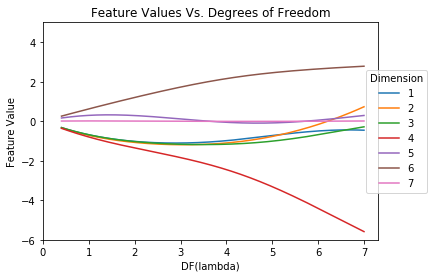

In [6]:
all_weights = np.matrix([ridge_regressors.info[lambda_param][0] for lambda_param in regularization_values]).T
all_dfs = [ridge_regressors.info[lambda_param][1] for lambda_param in regularization_values]
for i in range(X_train.shape[1]):
    plt.plot(all_dfs, all_weights[i].A1, label = str(i+1))
plt.ylim([-6,5])
plt.xlim([0,7.3])
plt.title('Feature Values Vs. Degrees of Freedom')
plt.xlabel('DF(lambda)')
plt.ylabel('Feature Value')
plt.legend(title = 'Dimension', loc='center left', bbox_to_anchor=(.95, 0.5))

### Prediction Error

In [7]:
predictions = ridge_regressors.multi_predict(X_test, np.arange(0, 51,1))

In [8]:
def RMSE(y_test, predicted):
    """Compute the Root Mean Squared Error between test target and predictions

    Parameters
    ----------
    y_test : {array-like, sparse matrix},
    shape = [n_samples]
        Test targets
        
    predicted : {array-like, sparse matrix},
    shape = [n_samples]
        predictions made on the test data
        
    Returns
    ----------
    rmse : float
        Root mean squared error between test targets and predictions
    """    
    rmse = np.sqrt(((y_test - predicted)**2).mean())
    return rmse 

In [9]:
all_rmse = [RMSE(y_test, predictions[lambda_param]) for lambda_param in np.arange(0, 51,1)]

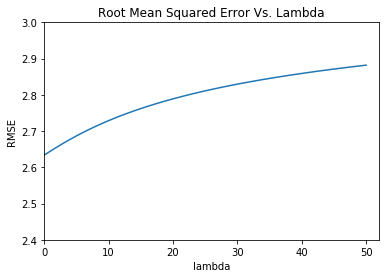

In [10]:
plt.plot(np.arange(0, 51,1), all_rmse)
plt.ylim([2.4,3])
plt.xlim([0,52])
plt.title('Root Mean Squared Error Vs. Lambda')
plt.xlabel('lambda')
plt.ylabel('RMSE')


### Learning a pth-order polynomial regression model for p = 1, 2, 3

In [11]:
def add_order_p(X, num_features, order):
    """Add p-th order polynomial to the data

    Parameters
    ----------
    X : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        data
        
    num_features : Integer
        Current number of features in the data
        
    order : Integer
        p-th order polynomial feature to add
        
    Returns
    ----------
    X_new : array-like
        Data with new p-th order polynomial feature added
    """  
    X_new = X.copy()
    for i in range(num_features):
        col = np.power(X_new[:, i], order)
        X_new = np.append(X_new, col[:, None], axis = 1)
    return X_new

In [12]:
regularization_values = np.arange(0, 501, 1)

In [13]:
p1_regressors = Ridge(X_train, y_train)
p1_regressors.multi_train(regularization_values)
predictions_p1 = p1_regressors.multi_predict(X_test, regularization_values)
p1rmse = [RMSE(y_test, predictions_p1[lambda_param]) for lambda_param in regularization_values]

In [14]:
p2_train, p2_test = add_order_p(X_train, X_train.shape[1], 2), add_order_p(X_test, X_test.shape[1], 2)
p2_regressors = Ridge(p2_train, y_train)
p2_regressors.multi_train(regularization_values)
predictions_p2 = p2_regressors.multi_predict(p2_test, regularization_values)
p2rmse = [RMSE(y_test, predictions_p2[lambda_param]) for lambda_param in regularization_values]

In [15]:
p3_train, p3_test = add_order_p(p2_train, X_train.shape[1], 3), add_order_p(p2_test, X_test.shape[1], 3)
p3_regressors = Ridge(p3_train, y_train)
p3_regressors.multi_train(regularization_values)
predictions_p3 = p3_regressors.multi_predict(p3_test, regularization_values)
p3rmse = [RMSE(y_test, predictions_p3[lambda_param]) for lambda_param in regularization_values]

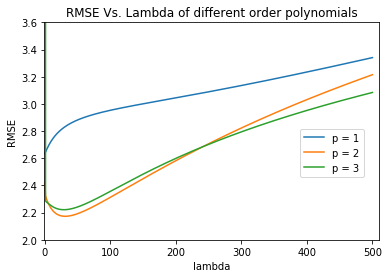

In [25]:
plt.plot(regularization_values, p1rmse, label = 'p = 1')
plt.plot(regularization_values, p2rmse, label = 'p = 2')
plt.plot(regularization_values, p3rmse, label = 'p = 3')
plt.ylim([2,3.6])
plt.xlim([-1,510])
plt.title('RMSE Vs. Lambda of different order polynomials')
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.legend(loc='center left', bbox_to_anchor=(.75, 0.4))